Here I want to have take the electron-nuclear spin register that Mohamed abobeih used in Delft. I want to see if we can distinguish all the nuclear spins with our method!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import cos, sin, pi, sqrt
from tqdm import tqdm
from scipy.fft import fft, fftfreq

In [2]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)


In [3]:
def anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc): ## Azz and Azx are np.array
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_b = 2*pi*np.sqrt((FL-Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(Azx/2, fL+Azz/2)     ## specific for spin 1/2
    Eta_b = np.arctan2(-Azx/2, fL-Azz/2)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4)
    return [ signal, term1 , term2, term3, term4]

def anal_eseem_spin_one(fL, Azz, Azx, tau1, tau2, tc, ms=1): ## Azz and Azx are np.array, ms = 1 or -1
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+ms*Azz)**2+Azx**2) ## Here is the only place we assume spin 1
    Ome_b = 2*pi*FL                                ## Here is the only place we assume spin 1
    Ome_plus = Ome_a + Ome_b
    Ome_minu = Ome_a - Ome_b
    Eta_a = np.arctan2(ms*Azx,fL+ms*Azz)   ## specific for spin 1
    Eta_b = 0                                 ## specific for spin 1
    Eta = (Eta_a - Eta_b)/2        
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_a = cos(Ome_a*tau1/2) *cos(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C_b = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *cos(Ome_b*tau1/2) *cos(Ome_b*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2

    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    term1 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term2 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_a 
                                            +4*K*cos(Eta)**4 *cos(Ome_a*tc+Phi_a_p+Phi_b_p)
                                            +2*K**2 *cos(Phi_b_m)*cos(Ome_a*tc+Phi_a_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_a*tc+Phi_a_p-Phi_b_p) ) 

    term3 = E_2p_tau1*E_2p_tau2 -B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) ) 

    term4 = E_2p_tau1*E_2p_tau2 +B*(-4*K**2 *C_b 
                                            +4*K*cos(Eta)**4 *cos(Ome_b*tc+Phi_b_p+Phi_a_p)
                                            +2*K**2 *cos(Phi_a_m)*cos(Ome_b*tc+Phi_b_p)
                                            +4*K*sin(Eta)**4 *cos(Ome_b*tc+Phi_b_p-Phi_a_p) )
    
    
    signal = np.prod(term1) - np.prod(term2) + np.prod(term3) -np.prod(term4)
    return [signal, term1 , term2, term3, term4] 


def anal_DD(fL, Azz, Azx, tau, N_pi, ms=1): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    Thet= np.arccos(cos(Ome_L*tau)*cos(Ome_h*tau)-((Ome_L+Azz)/Ome_h)*sin(Ome_L*tau)*sin(Ome_h*tau))
    sigma_z = 1-(Azx/Ome_h)**2*(1-cos(Ome_L*tau))*(1-cos(Ome_h*tau))*sin(N_pi/2*Thet)**2/(1+cos(Thet))  
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
#     p2 = -Azx**2 *s1*s0*(OmeL+s0*Azz)*(OmeL+s1*Azz)/Ome0**2/Ome1**2
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
#     one_minus_dot+= p2*(2*sin(Ome0*tau)*sin(Ome1*tau)/sin(Thet))**2
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
    return -np.prod(sigma_z)

def anal_Hahn_echo(fL, Azz, Azx, tau, ms=1): #Azz and Azx are np.array, ms = 1 or -1
    Ome_L = 2*pi*fL
    Azz, Azx = 2*pi*ms*Azz, 2*pi*ms*Azx
    Ome_h = np.sqrt((Ome_L+Azz)**2+Azx**2) #
    
    sigma_z = 1-2*(Azx/Ome_h)**2 *sin(Ome_L*tau/2)**2 *sin(Ome_h*tau/2)**2  
    return -np.prod(sigma_z)

def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state


In [6]:
anal_DD_general(fL, Azz, Azx, 9.245e-3, 64, s1=1, s0=-1)

-0.9885036182071167

# Let's define the nuclear spin register couplings (C1 to C23)

In [4]:
%matplotlib notebook
# determining the parameters
fL = 403.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=431.94493014999995 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[411.39997955 408.9316184  400.77478345 418.07709486 424.74614082
 383.47055906 423.63555262 422.18453909 645.10590579 449.67017573
 446.60489997 454.41383901 440.4748111  412.1640078  418.0808126
 427.34226509 426.3542495  396.53146773 457.01785379 434.77410515
 433.35196565 439.64612698 428.77259465] kHz
Blind Spot up=[2.43072448 2.44539663 2.49516696 2.39190334 2.35434747 2.60776213
 2.36051954 2.36863245 1.55013307 2.22385218 2.2391156  2.2006372
 2.27027738 2.42621864 2.39188207 2.34004469 2.34546742 2.52186795
 2.18809832 2.30004498 2.30759309 2.2745566  2.33223861] us
Freq hyp dn=[452.82396026 

<IPython.core.display.Javascript object>


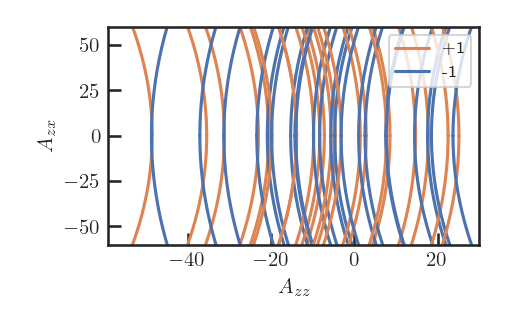

In [1403]:
angle = np.linspace( 0 , 2 * np.pi , int(1e3) ) 

x_up, y_up, x_dn, y_dn, txt= [],[],[],[],[]
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
for i, fh_up in enumerate(Fh_up):
    #i, fh_up = 9, Fh_up[9]
    x_up = -fL+ fh_up * np.cos( angle ) 
    y_up = fh_up * np.sin( angle )

    x_dn = fL- Fh_dn[i] * np.cos( angle ) 
    y_dn = Fh_dn[i] * np.sin( angle )

    plt.plot( x_up, y_up , color='C1') 
    plt.plot( x_dn, y_dn , color='C0')
    


    
plt.xlabel(r'$A_{zz}$')
plt.ylabel(r'$A_{zx}$')
plt.tight_layout()
plt.legend(['+1','-1'], loc=1)
plt.xticks([-fL, fL], ['-$f_L$', '+$f_L$'])
plt.savefig('coupling_circ.pdf')


In [ ]:
# plt.xlim([-59,30])
# plt.ylim([-60,60])
# plt.savefig('coupling_circ_zoom.pdf')

# Hahn Echo

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 68967.11it/s]


<IPython.core.display.Javascript object>


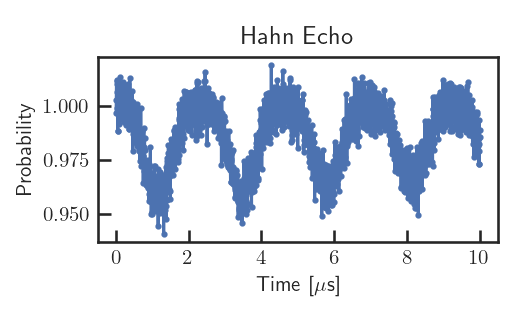

In [23]:
start = 10e-6 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_meas = int(1e4)

Signal = []
for tau in tqdm(Taus):
    sigma_z = anal_Hahn_echo(fL, Azz, Azx, tau, ms=1)
    Signal.append(sigma_z)
Signal = np.array(Signal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_noisy, '-o',markersize=2, alpha = 1)
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('Hahn Echo')
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

# Dynamical Decoupling

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 45455.38it/s]


<IPython.core.display.Javascript object>


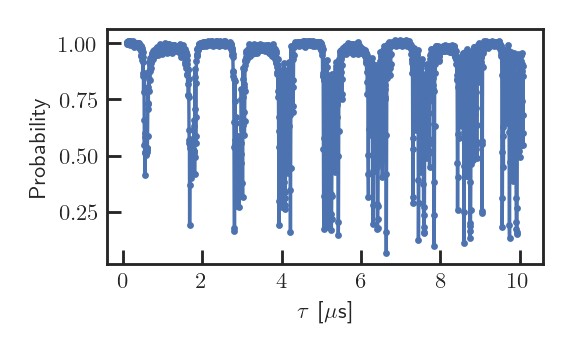

In [22]:
start = 0.1e-3 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Signal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD(fL, Azz, Azx, tau, N_pi, ms=1)
    Signal.append(sigma_z)
Signal = np.array(Signal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_noisy, '-o',markersize=2, alpha = 1)
plt.xlabel(r"$\tau$ [$\mu$s]")
plt.ylabel('Probability')
#plt.title('Dynamical Decoupling')
plt.tight_layout()
# plt.savefig('DD_behavior.pdf')

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 42692.29it/s]


<IPython.core.display.Javascript object>


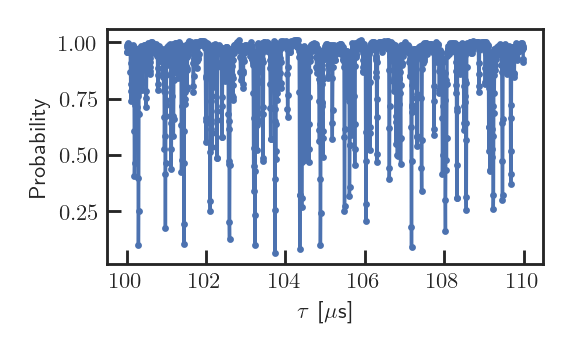

In [44]:
start = 100e-3 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Signal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD(fL, Azz, Azx, tau, N_pi, ms=1)
    Signal.append(sigma_z)
Signal = np.array(Signal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_noisy, '-o',markersize=2, alpha = 1)
plt.xlabel(r"$\tau$ [$\mu$s]")
plt.ylabel('Probability')
#plt.title('Dynamical Decoupling')
plt.tight_layout()
plt.savefig('DD_nuc.pdf')

# DD for SiV vs NV

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 25973.17it/s]


<IPython.core.display.Javascript object>


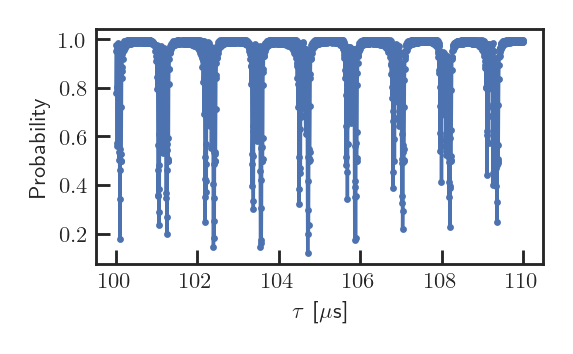

100%|███████████████████████████████████| 2000/2000 [00:00<00:00, 28363.94it/s]


<IPython.core.display.Javascript object>


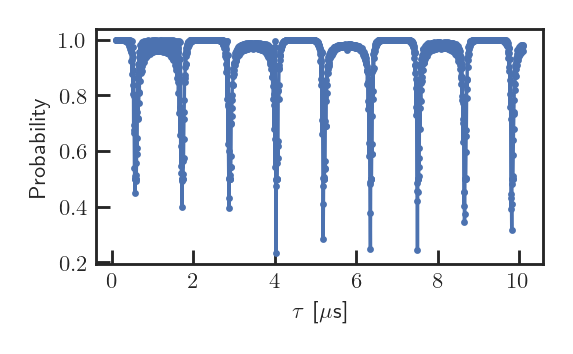

In [94]:
start = 100e-3 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    Signal_anal.append(sigma_z)

Signal_anal = np.array(Signal_anal)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1)
plt.xlabel(r"$\tau$ [$\mu$s]")
plt.ylabel('Probability')
# plt.title('DD spin 1')
plt.tight_layout()
plt.savefig('dd_onehalf_long.pdf')
############################################################
start = 0.1e-3 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)
Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    Signal_anal.append(sigma_z)

Signal_anal = np.array(Signal_anal)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1)
plt.xlabel(r"$\tau$ [$\mu$s]")
plt.ylabel('Probability')
# plt.title('DD spin 1/2')
plt.tight_layout()
plt.savefig('dd_onehalf.pdf')


# Let's see the spectrum only for one tau

# Left and right measurements

<IPython.core.display.Javascript object>


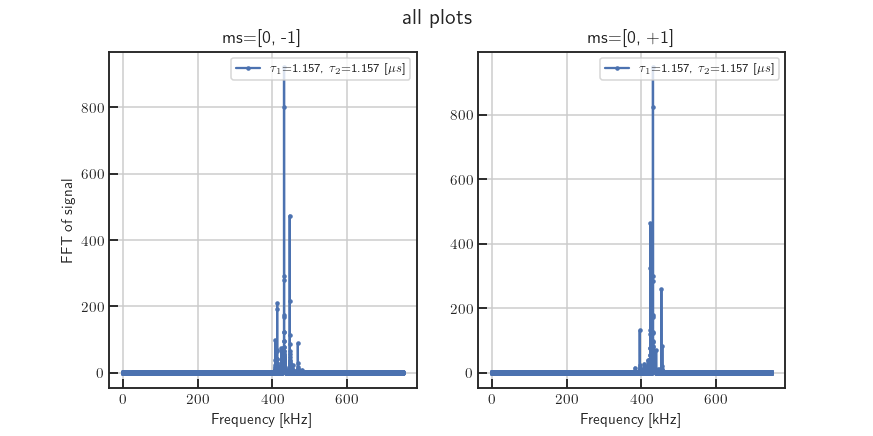

100%|██████████████████████████████████| 75000/75000 [00:10<00:00, 6964.30it/s]


<IPython.core.display.Javascript object>


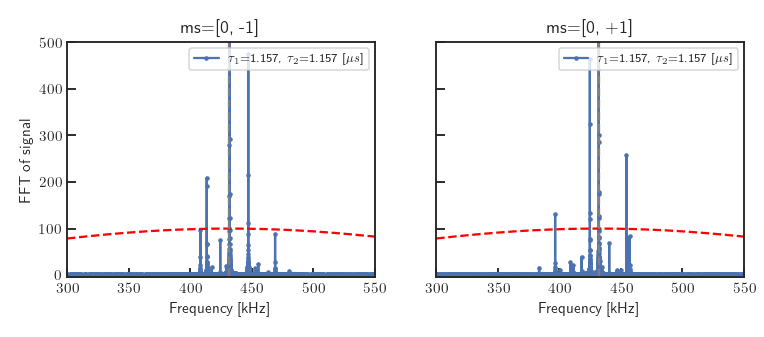

In [108]:
start = 1e-3 # in ms
duration = 50 # in ms
steps = 75000
Tc = np.linspace(start,start+duration, steps) # in ms
N_meas = int(5e4)

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,2, sharey=False, figsize=(8, 4), dpi=100)
#fig_all.subplots_adjust(wspace=0.08)
for tau1l, tau2l,tau1r, tau2r,txt in [[.5/432, .5/432,.5/432,.5/432, 'Larmor bright'] ]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1l, tau2l, tc, ms=-1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    p_noisy = Generate_noisy_signal(p, N_meas)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p_noisy))[1:int(steps/2)]

    ###### ploting part
    fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5/1.61803398875),dpi=100)
    #fig.subplots_adjust(wspace=0.08)
    #fig.suptitle(txt)
    ax[0].set_title('ms=[0, -1]')
    ax[0].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    ax[0].plot(freqs, 100*sin(2*pi*fL*tau1l/2)*sin(2*pi*fL*tau2l/2)*sin(2*pi*freqs*tau1l/2)*sin(2*pi*freqs*tau2l/2),
               '--', color='red')
    ax_all[0].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))) )
    ax[0].set_xlabel('Frequency [kHz]')
    ax[0].set_ylabel('FFT of signal')
    
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1r, tau2r, tc, ms=1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    p_noisy = Generate_noisy_signal(p, N_meas)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p_noisy))[1:int(steps/2)]
    ax[1].set_title('ms=[0, +1]')
    ax[1].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))))
    ax[1].plot(freqs, 100*sin(2*pi*fL*tau1l/2)*sin(2*pi*fL*tau2l/2)*sin(2*pi*freqs*tau1l/2)*sin(2*pi*freqs*tau2l/2),
               '--', color='red')
    ax_all[1].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,
            label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))) )
    ax[1].set_xlabel('Frequency [kHz]')
#     ax[0].grid()
#     ax[1].grid()
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2, hspace=0)
    ax[0].axvline(x=fL, linestyle='--',color='gray')
    ax[1].axvline(x=fL, linestyle='--',color='gray')
    #fig.savefig('eseem.pdf')

ax_all[0].set_title('ms=[0, -1]')
ax_all[1].set_title('ms=[0, +1]')
fig_all.suptitle('all plots')
ax_all[0].set_xlabel('Frequency [kHz]')
ax_all[1].set_xlabel('Frequency [kHz]')
ax_all[0].set_ylabel('FFT of signal')
ax_all[0].legend(loc='upper right')
ax_all[1].legend(loc='upper right')
ax_all[0].grid()
ax_all[1].grid()


In [111]:
ax[0].set_xlim([300, 550])
ax[1].set_xlim([300, 550])
ax[0].set_ylim([-5, 500])
ax[1].set_ylim([-5, 500])
# fig.savefig('eseem.pdf')


# Double Quantum Resonance measurements

# Sweep Tc

100%|██████████████████████████████████| 15000/15000 [00:02<00:00, 6752.22it/s]


<IPython.core.display.Javascript object>


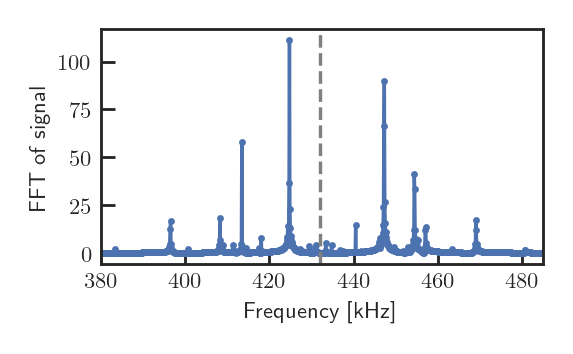

In [27]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
Tc = np.linspace(start,start+duration, steps) # in ms
N_meas = int(1e4)
sample_rate = steps/duration # in kHz
#fig_all,ax_all = plt.subplots(dpi=100)

for tau1, tau2, txt in [[0.5/440, 0.5/440, 'nothing blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p))[1:int(steps/2)]

#     plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#     plt.plot(Tc, p_noisy, '-o', ms=2, alpha=1)
#     plt.xlabel('Tc [ms]')
#     plt.ylabel('Probability')
#     plt.tight_layout()
#     plt.xlim([0.5,1])
#     plt.savefig('DQR_time.pdf')
    
    plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
    #plt.title(txt)
    plt.plot(freqs, FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1<np.max(freqs):plt.vlines(x=i/tau1,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2<np.max(freqs):plt.vlines(x=i/tau2,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('FFT of signal')
    plt.axvline(x=fL, linestyle='--',color='gray')
    plt.xlim([380, 485])
    plt.tight_layout()
    #plt.savefig('DQR_high_res.pdf')
    
#     ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
#                    +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )

# ax_all.set_title('all plots')
# ax_all.set_xlabel('Frequency [kHz]')
# ax_all.set_ylabel('FFT of signal')
# ax_all.legend(loc='upper right')
# ax_all.grid()

In [1138]:
#Larmor_line = plt.axvline(x=fL, linestyle='--',color='gray')
#plt.savefig('DQR_high_res_zoom.pdf')

In [7]:
# Generating colors
import colorsys
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors
Cols = _get_colors(25)

<IPython.core.display.Javascript object>


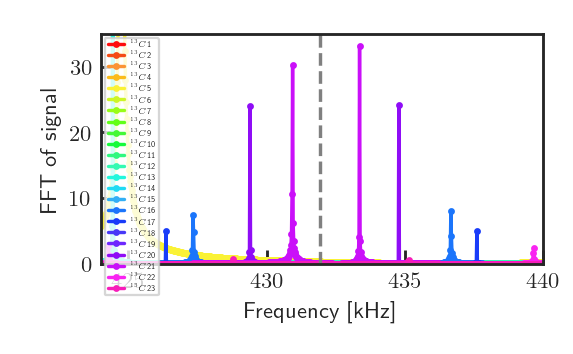

23it [01:29,  3.90s/it]


In [30]:
start = 1e-3 # in ms
duration = 50 # in ms
steps = 75000
Tc = np.linspace(start,start+duration, steps) # in ms
N_meas = int(1e4)
sample_rate = steps/duration # in kHz
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
tau1, tau2= 0.5/440, 0.5/440
for i, value in tqdm(enumerate(Azz)):
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz[i], Azx[i], tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    #p_noisy = Generate_noisy_signal(p, N_meas)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p))[1:int(steps/2)]
    plt.plot(freqs, FFT_Signal,'-o',markersize=2, color=Cols[i], label=r'$^{13}C$'+'{}'.format(i+1))

# tau1, tau2= 0.5/440, 0.5/440
# Term1 = []
# Term2 = []
# Term3 = []
# Term4 = []
# Signal = []
# for tc in Tc:
#     [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
#     Term1.append(term1)
#     Term2.append(term2)
#     Term3.append(term3)
#     Term4.append(term4)
#     Signal.append(signal)
# Signal = np.array(Signal)
# p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
# #p_noisy = Generate_noisy_signal(p, N_meas)
# freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
# FFT_Signal = np.abs(np.fft.rfft(p))[1:int(steps/2)]
# plt.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=0.6, color='black', label='All $^{13}C$')

plt.xlabel('Frequency [kHz]')
plt.ylabel('FFT of signal')
plt.axvline(x=fL, linestyle='--',color='gray')
plt.xlim([380, 485])
plt.tight_layout()
plt.legend(fontsize=3.5,loc=2)
plt.savefig('5peseem_color.png', dpi=150)

In [45]:
plt.xlim([424, 440])
plt.ylim([0, 35])
plt.savefig('5peseem_color_zoom.png', dpi=150)

# DQR Sweeping tau

In [1178]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 15000
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz
N_meas= int(1e4)

spect = []
signal2D = []

tau_sweep = np.arange(1e-3,500e-3,10e-3)
for tau1 in tqdm(tau_sweep):
    tau2 =tau1
    ###################################### left
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)
    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    p_noisy = Generate_noisy_signal(p, N_meas)
    
    signal2D.append(p_noisy)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(p_noisy))[1:int(steps/2)]
    spect.append(FFT_Signal)


signal2D= np.array(signal2D)
spect= np.array(spect)

100%|██████████████████████████████████████████| 50/50 [06:01<00:00,  7.22s/it]


<IPython.core.display.Javascript object>


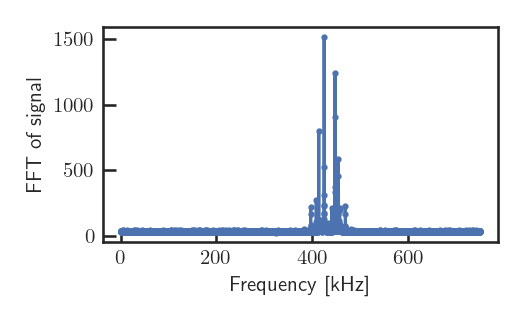

In [1198]:
accum_spect = np.sum(spect, axis=0)
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
#plt.title('Accumulated signal')
plt.plot(freqs, accum_spect,'-o',markersize=2, alpha = 1)
plt.xlabel('Frequency [kHz]')
plt.ylabel('FFT of signal')
plt.tight_layout()
plt.savefig('Accum_tau_sweep.pdf')

<IPython.core.display.Javascript object>


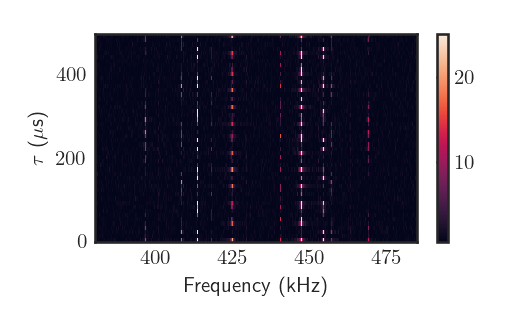

In [1214]:
x,y=np.meshgrid(freqs, tau_sweep*1e3)
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.pcolormesh(x,y,spect, vmin=.5, vmax=25, rasterized=True)
#plt.title('Amplitude')
plt.xlabel('Frequency (kHz)')
plt.ylabel(r'$\tau$ ($\mu$s)')
plt.colorbar()
plt.tight_layout()
plt.xlim([380, 485])
plt.savefig('tau_sweep.pdf')
#plt.grid()

4569


<IPython.core.display.Javascript object>


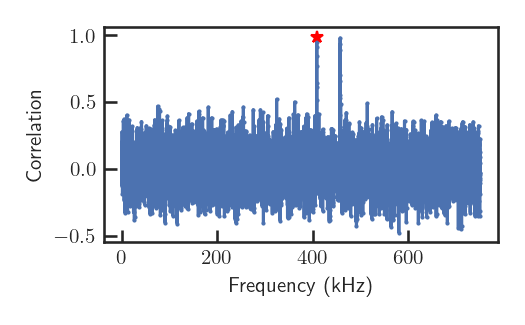

457.0 408.3


In [1239]:
i=np.argwhere(freqs == 457)[0][0]
print(i)
s1= spect[:,i]
s1 = s1 -np.mean(s1)
Corr1D = []
for j in range(len(spect[0,:])):
    if j==i: Corr1D.append(0); continue
    s2= spect[:,j]
    s2 = s2 -np.mean(s2)
    corr = np.sum(s1*s2)/np.sqrt(np.sum(s1*s1)* np.sum(s2*s2))
    Corr1D.append(corr)
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(freqs, Corr1D, '-o', ms=1)
plt.plot(freqs[np.argmax(Corr1D)], np.max(Corr1D), '*', ms= 6, color= 'red')
plt.xlabel('Frequency (kHz)')
plt.ylabel(r'Correlation')
plt.tight_layout()
#plt.xlim([380, 485])
#plt.savefig('corr1D.pdf')
print(freqs[i],freqs[np.argmax(Corr1D)])


In [1217]:
Corr2D= []
for i in tqdm(range(len(spect[0,:]))):
    s1= spect[:,i]
    s1 = s1 -np.mean(s1)
    Corr1D = []
    for j in range(len(spect[0,:])):
        if j==i: Corr1D.append(0); continue
        s2= spect[:,j]
        s2 = s2 -np.mean(s2)
        corr = np.sum(s1*s2)/np.sqrt(np.sum(s1*s1)* np.sum(s2*s2))
        Corr1D.append(corr)
    Corr2D.append(Corr1D)

Corr2D = np.array(Corr2D)

100%|██████████████████████████████████████| 7499/7499 [11:21<00:00, 11.00it/s]


<IPython.core.display.Javascript object>


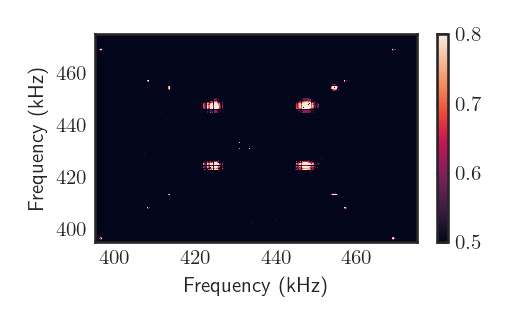

136.4 127.5


In [1242]:
x,y = np.meshgrid(freqs,freqs)
plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.pcolormesh(x, y, Corr2D, vmin=0.5, vmax= 0.8, rasterized=True)
#plt.title('Correlation')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Frequency (kHz)')
plt.colorbar()
plt.xlim([395, 475])
plt.ylim([395, 475])
plt.tight_layout()
# plt.savefig('corr2D.pdf')
print(freqs[1363],freqs[1274])

<IPython.core.display.Javascript object>


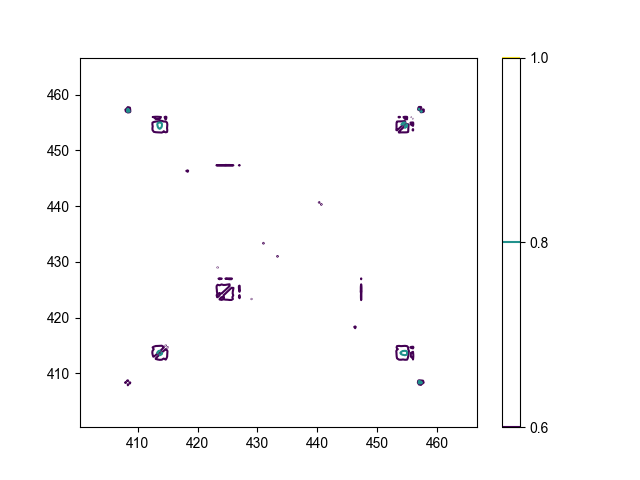

In [975]:
plt.figure()
sl = slice(1200,1400)
ccut = Corr2D[sl,sl]
xsl = ccut[0,:]
ysl = ccut[:,0]

plt.contour(x[sl, sl],y[sl,sl], ccut- np.sqrt(np.abs(xsl[:, np.newaxis]*ysl[np.newaxis,:])), levels=[0.6,0.8, 1])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


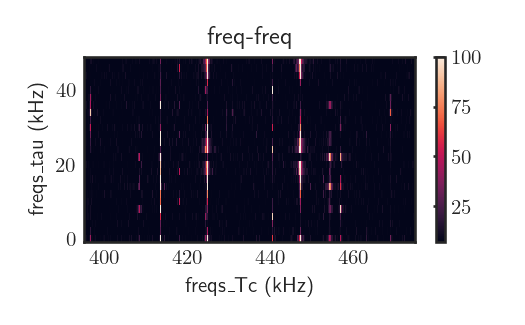

In [1299]:
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
freqs_tau = np.fft.fftfreq(n=tau_sweep.shape[0], d = tau_sweep[1]-tau_sweep[0])
# x_freq= np.append(freqs_Tc[int(len(freqs_Tc)/2):], freqs_Tc[:int(len(freqs_Tc)/2)])
# y_freq= np.append(freqs_tau[int(len(freqs_tau)/2):], freqs_tau[:int(len(freqs_tau)/2)])
x1,y1 = np.meshgrid(freqs_Tc[:int(len(freqs_Tc)/2)],freqs_tau[:int(len(freqs_tau)/2)])

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.pcolormesh(x1,y1, np.abs(np.fft.fft2(signal2D))[:int(len(freqs_tau)/2),:int(len(freqs_Tc)/2)], vmin=7, vmax= 1e2,
               rasterized=True)
#plt.contourf(signal2D)
plt.title('freq-freq')
plt.xlabel('freqs_Tc (kHz)')
plt.ylabel('freqs_tau (kHz)')
plt.xlim([395, 475])
plt.colorbar()
plt.tight_layout()

In [1294]:
np.abs(np.fft.fft2(signal2D))[:int(len(freqs_tau)/2),:int(len(freqs_Tc)/2)].shape

(25, 7500)

# 2D Hyscore

In [1300]:
def anal_hyscore_spin_one_DQR(fL, Azz, Azx, tau1, tau2, t1, t2): ## Azz and Azx are np.array
    FL = fL*np.ones_like(Azz,dtype=float)
    Ome_a = 2*pi*np.sqrt((FL+Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_b = 2*pi*np.sqrt((FL-Azz)**2+(Azx)**2) ## specific for spin 1/2
    Ome_plus = Ome_a + Ome_a
    Ome_minu = Ome_b - Ome_b
    Eta_a = np.arctan2(Azx/2, fL+Azz/2)     ## specific for spin 1/2
    Eta_b = np.arctan2(-Azx/2, fL-Azz/2)    ## specific for spin 1/2
    Eta = (Eta_a - Eta_b)/2
    K = sin(2*Eta)**2
    B = sin(Ome_a*tau1/2) *sin(Ome_a*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_b*tau2/2)
    C0 = cos(Ome_a*tau1/2) *cos(Ome_b*tau2/2) *sin(Ome_b*tau1/2) *sin(Ome_a*tau2/2)
    Phi_a_p = Ome_a*(tau1+tau2)/2
    Phi_a_m = Ome_a*(tau1-tau2)/2
    Phi_b_p = Ome_b*(tau1+tau2)/2
    Phi_b_m = Ome_b*(tau1-tau2)/2
    
    Cc = cos(Ome_a*t1+Phi_a_p+Phi_b_m) -cos(Ome_a*t1+Phi_a_m+Phi_b_m)
    Cc +=cos(Ome_a*t1+Phi_a_p+Phi_b_p) -cos(Ome_a*t1+Phi_a_m+Phi_b_p) 
    Cc +=cos(Ome_b*t2-Phi_a_m+Phi_b_p) -cos(Ome_b*t2-Phi_a_m-Phi_b_m) 
    Cc +=cos(Ome_b*t2+Phi_a_p+Phi_b_p) -cos(Ome_b*t2+Phi_a_p-Phi_b_m)
        
    Cs = cos(Ome_a*t1+Phi_a_p-Phi_b_m) -cos(Ome_a*t1+Phi_a_m-Phi_b_m)
    Cs +=cos(Ome_a*t1+Phi_a_p-Phi_b_p) -cos(Ome_a*t1+Phi_a_m-Phi_b_p) 
    Cs +=cos(Ome_b*t2-Phi_a_p+Phi_b_p) -cos(Ome_b*t2-Phi_a_p-Phi_b_m) 
    Cs +=cos(Ome_b*t2+Phi_a_m+Phi_b_p) -cos(Ome_b*t2+Phi_a_m-Phi_b_m)
    
    E_2p_tau1 = 1-K/2 + K/2*(cos(Ome_a*tau1) +cos(Ome_b*tau1) 
                              -0.5*cos(Ome_minu*tau1) -0.5*cos(Ome_plus*tau1))
    E_2p_tau2 = 1-K/2 + K/2*(cos(Ome_a*tau2) +cos(Ome_b*tau2) 
                              -0.5*cos(Ome_minu*tau2) -0.5*cos(Ome_plus*tau2))

    Eab_p = E_2p_tau1*E_2p_tau2 -K*B*(4*K*cos(2*Eta) *C0 
                                        +4*cos(Eta)**6 *cos(Ome_a*t1+Ome_b*t2 +Phi_a_p+Phi_b_p)
                                        +4*sin(Eta)**6 *cos(Ome_a*t1-Ome_b*t2 +Phi_a_p-Phi_b_p)
                                        +K*cos(Eta)**2*(Cc+cos(Ome_a*t1+Ome_b*t2 +Phi_a_p-Phi_b_m)
                                                             +cos(Ome_a*t1+Ome_b*t2 +Phi_a_m+Phi_b_p)
                                                             +cos(Ome_a*t1-Ome_b*t2 +Phi_a_m+Phi_b_m))
                                        +K*sin(Eta)**2*(Cs+cos(Ome_a*t1-Ome_b*t2 +Phi_a_p+Phi_b_m)
                                                             +cos(Ome_a*t1-Ome_b*t2 -Phi_a_m+Phi_b_p)
                                                             +cos(Ome_a*t1+Ome_b*t2 -Phi_a_m+Phi_b_m)) )

    Eab_m = E_2p_tau1*E_2p_tau2 +K*B*(4*K*cos(2*Eta) *C0 
                                        +4*cos(Eta)**6 *cos(Ome_a*t1+Ome_b*t2 +Phi_a_p+Phi_b_p)
                                        +4*sin(Eta)**6 *cos(Ome_a*t1-Ome_b*t2 +Phi_a_p-Phi_b_p)
                                        +K*cos(Eta)**2*(Cc+cos(Ome_a*t1+Ome_b*t2 +Phi_a_p-Phi_b_m)
                                                             +cos(Ome_a*t1+Ome_b*t2 +Phi_a_m+Phi_b_p)
                                                             +cos(Ome_a*t1-Ome_b*t2 +Phi_a_m+Phi_b_m))
                                        +K*sin(Eta)**2*(Cs+cos(Ome_a*t1-Ome_b*t2 +Phi_a_p+Phi_b_m)
                                                             +cos(Ome_a*t1-Ome_b*t2 -Phi_a_m+Phi_b_p)
                                                             +cos(Ome_a*t1+Ome_b*t2 -Phi_a_m+Phi_b_m)) ) 

    Eba_p = E_2p_tau1*E_2p_tau2 -K*B*(4*K*cos(2*Eta) *C0 
                                        +4*cos(Eta)**6 *cos(Ome_b*t1+Ome_a*t2 +Phi_b_p+Phi_a_p)
                                        +4*sin(Eta)**6 *cos(Ome_b*t1-Ome_a*t2 +Phi_b_p-Phi_a_p)
                                        +K*cos(Eta)**2*(Cc+cos(Ome_b*t1+Ome_a*t2 +Phi_b_p-Phi_a_m)
                                                             +cos(Ome_b*t1+Ome_a*t2 +Phi_b_m+Phi_a_p)
                                                             +cos(Ome_b*t1-Ome_a*t2 +Phi_b_m+Phi_a_m))
                                        +K*sin(Eta)**2*(Cs+cos(Ome_b*t1-Ome_a*t2 +Phi_b_p+Phi_a_m)
                                                             +cos(Ome_b*t1-Ome_a*t2 -Phi_b_m+Phi_a_p)
                                                             +cos(Ome_b*t1+Ome_a*t2 -Phi_b_m+Phi_a_m)) ) 

    Eba_m = E_2p_tau1*E_2p_tau2 +K*B*(4*K*cos(2*Eta) *C0 
                                        +4*cos(Eta)**6 *cos(Ome_b*t1+Ome_a*t2 +Phi_b_p+Phi_a_p)
                                        +4*sin(Eta)**6 *cos(Ome_b*t1-Ome_a*t2 +Phi_b_p-Phi_a_p)
                                        +K*cos(Eta)**2*(Cc+cos(Ome_b*t1+Ome_a*t2 +Phi_b_p-Phi_a_m)
                                                             +cos(Ome_b*t1+Ome_a*t2 +Phi_b_m+Phi_a_p)
                                                             +cos(Ome_b*t1-Ome_a*t2 +Phi_b_m+Phi_a_m))
                                        +K*sin(Eta)**2*(Cs+cos(Ome_b*t1-Ome_a*t2 +Phi_b_p+Phi_a_m)
                                                             +cos(Ome_b*t1-Ome_a*t2 -Phi_b_m+Phi_a_p)
                                                             +cos(Ome_b*t1+Ome_a*t2 -Phi_b_m+Phi_a_m)) )
    
    
    signal = np.prod(Eab_p) - np.prod(Eab_m) + np.prod(Eba_p) -np.prod(Eba_m)
    return [ signal, Eab_p , Eab_m, Eba_p, Eba_m]

In [1302]:
start = 1e-3 # in ms
duration = 1 # in ms
steps = 1500
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz
N_meas = int(1e4)

signal2D = []
tau1, tau2 = 2e-3, 2e-3

for t1 in tqdm(Tc):

    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for t2 in Tc:
        [signal, term1 , term2, term3, term4]= anal_hyscore_spin_one_DQR(fL, Azz, Azx, tau1, tau2, t1, t2)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    Signal = np.array(Signal)
    p = 0.5+0.125*Signal # probability to come back to initial state (bright state)
    p_noisy = Generate_noisy_signal(p, N_meas)
    signal2D.append(p_noisy)


signal2D= np.array(signal2D)

100%|██████████████████████████████████████| 1500/1500 [21:45<00:00,  1.15it/s]


<IPython.core.display.Javascript object>


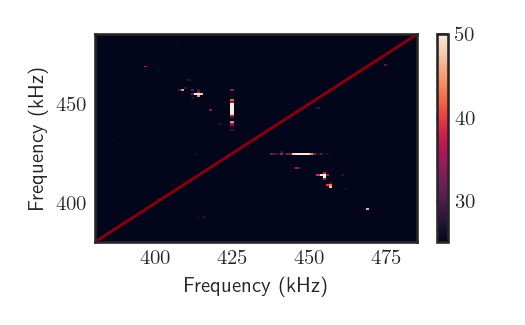

In [1324]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
# x_freq= np.append(freqs_Tc[int(len(freqs_Tc)/2):], freqs_Tc[:int(len(freqs_Tc)/2)])
# y_freq= np.append(freqs_tau[int(len(freqs_tau)/2):], freqs_tau[:int(len(freqs_tau)/2)])
x, y = np.meshgrid(freqs_Tc[:int(len(freqs_Tc)/2)],freqs_Tc[:int(len(freqs_Tc)/2)])

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.pcolormesh(x, y, FFT2D_Signal[:int(len(freqs_Tc)/2), :int(len(freqs_Tc)/2)], vmin=25, vmax=50, rasterized=True)
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
#plt.title('2D Hyscore DQR')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Frequency (kHz)')
plt.xlim([380, 485])
plt.ylim([380, 485])
plt.colorbar()
plt.tight_layout()
#plt.savefig('2DHyscore.pdf')

<IPython.core.display.Javascript object>


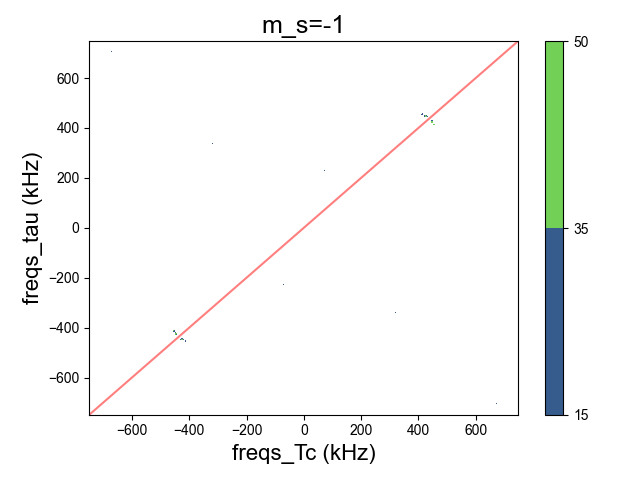

In [1004]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.contourf(x,y, FFT2D_Signal, levels= [15, 35, 50])
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


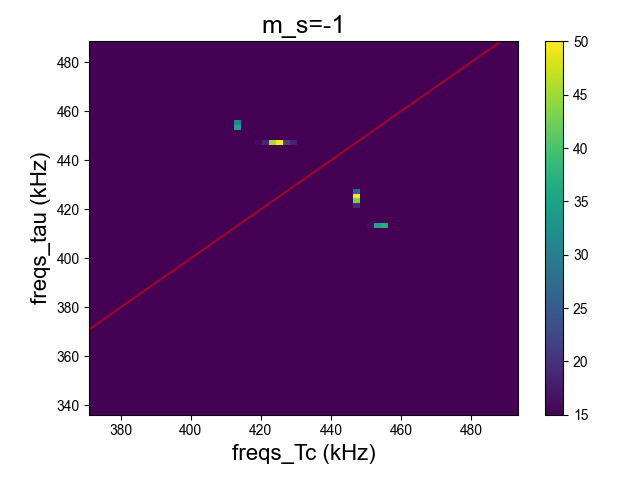

In [1005]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.pcolormesh(x[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               y[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               FFT2D_Signal[0:int(len(Tc)/2), 0:int(len(Tc)/2)], vmin=15, vmax=50)
plt.pcolormesh(x[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               y[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               FFT2D_Signal[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))], vmin=15, vmax=50)
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

# LOW MAGNETIC FIELD

In [269]:
%matplotlib notebook
# determining the parameters
fL = 83*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=88.8515 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[ 69.18020882  66.906605    58.15438764  75.90304831  97.53423312
  41.26492109  80.58735938  79.219447   302.02040002 106.84118368
 103.88193587 117.02959421  99.13037516  69.23964422  75.42935099
  84.48200206  83.38154827  58.90198462 115.93624045  92.20003374
  90.99689023  96.61733639  85.69784099] kHz
Blind Spot up=[14.45500118 14.94620748 17.19560708 13.17470144 10.2528104  24.23365836
 12.408894   12.6231631   3.31103462  9.35968664  9.62631271  8.5448472
 10.08772537 14.44259299 13.25743874 11.8368407  11.99306106 16.97735664
  8.62543063 10.84598302 10.98938653 10.35010938 11.66890541] us
Freq hyp dn=[

<IPython.core.display.Javascript object>


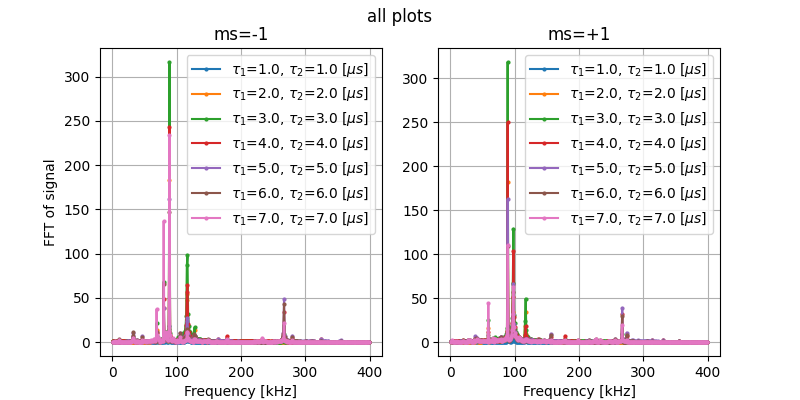

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1501.93it/s]


<IPython.core.display.Javascript object>


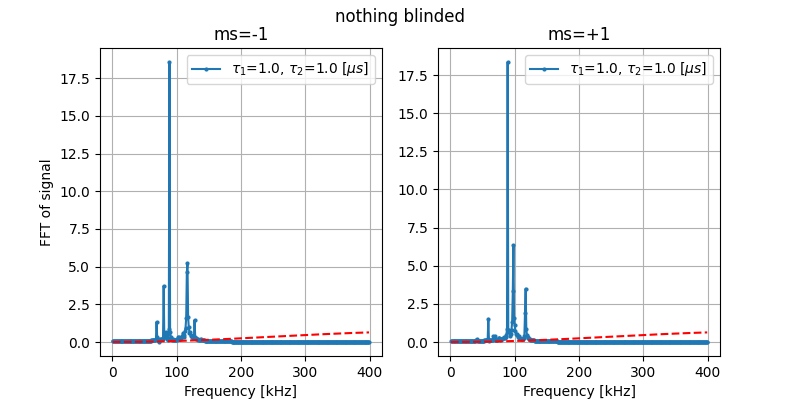

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1519.02it/s]


<IPython.core.display.Javascript object>


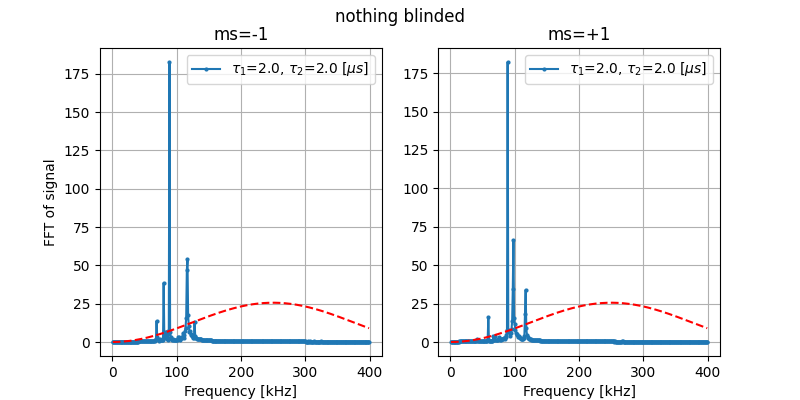

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1495.94it/s]


<IPython.core.display.Javascript object>


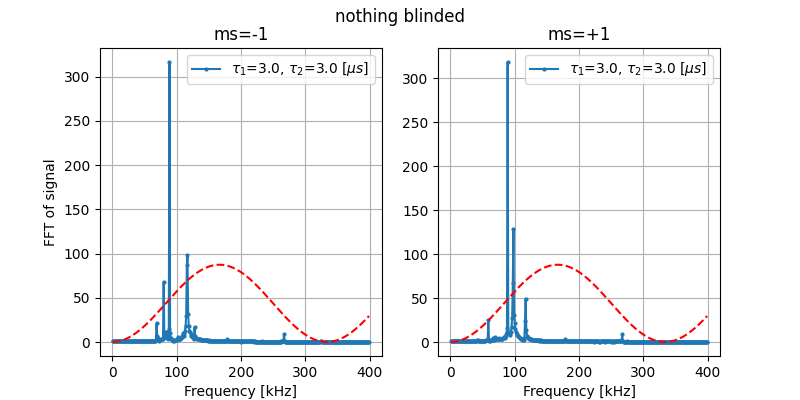

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1489.58it/s]


<IPython.core.display.Javascript object>


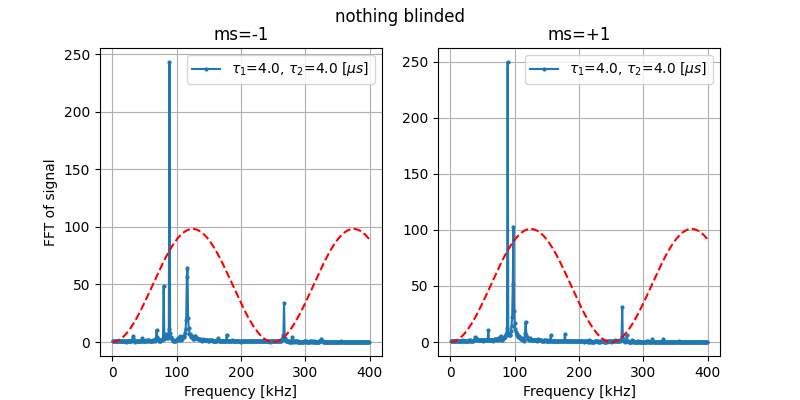

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1504.57it/s]


<IPython.core.display.Javascript object>


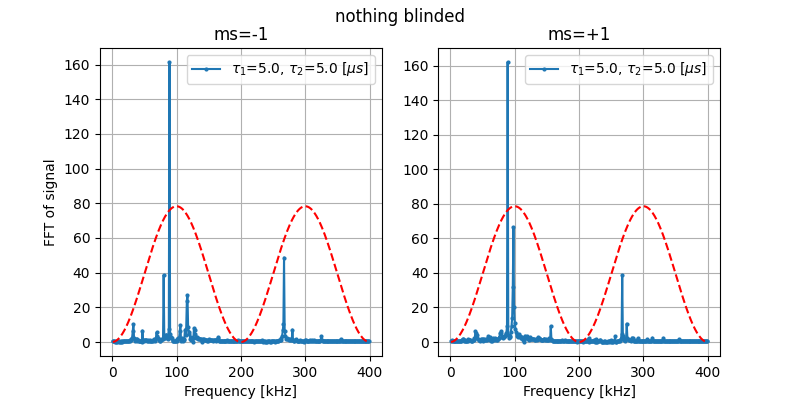

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1471.39it/s]
C:\Users\majid\AppData\Local\Temp\ipykernel_10108\79127975.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(1,2, sharey=False, figsize=(8, 4),dpi=100)


<IPython.core.display.Javascript object>


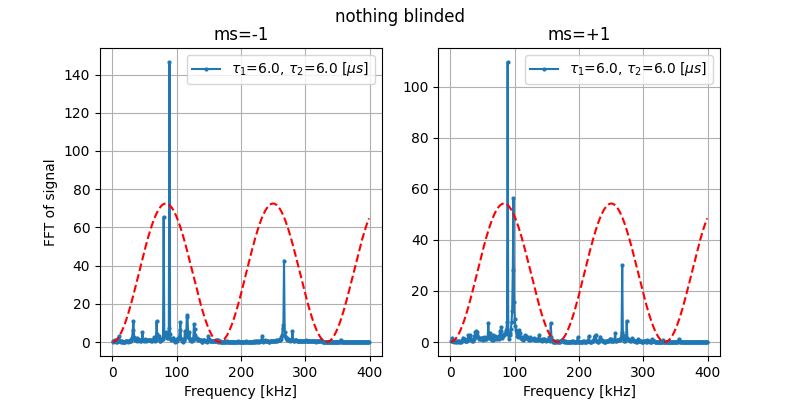

100%|██████████████████████████████████████| 800/800 [00:00<00:00, 1507.21it/s]


<IPython.core.display.Javascript object>


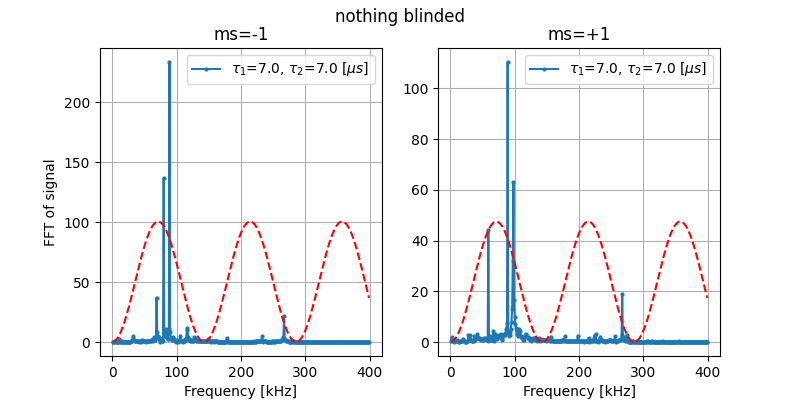

In [283]:
start = 1e-3 # in ms
duration = 1 # in ms
steps = 800
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(1,2, sharey=False, figsize=(8, 4), dpi=100)
#fig_all.subplots_adjust(wspace=0.08)
for tau1l, tau2l,tau1r, tau2r,txt in [[1.0e-3, 1.0e-3,1.0e-3, 1.0e-3, 'nothing blinded'],
                                      [2.0e-3, 2.0e-3,2.0e-3, 2.0e-3, 'nothing blinded'],
                                      [3.0e-3, 3.0e-3,3.0e-3, 3.0e-3, 'nothing blinded'],
                                      [4.0e-3, 4.0e-3,4.0e-3, 4.0e-3, 'nothing blinded'],
                                      [5.0e-3, 5.0e-3,5.0e-3, 5.0e-3, 'nothing blinded'],
                                      [6.0e-3, 6.0e-3,6.0e-3, 6.0e-3, 'nothing blinded'],
                                      [7.0e-3, 7.0e-3,7.0e-3, 7.0e-3, 'nothing blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1l, tau2l, tc, ms=-1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ## Finding Max of each peak with filtering
    #from_index, to_index = int(steps/4), int(1.15*steps/4)
    #sub_freqs = freqs[from_index:to_index]
    #sub_FFT_Signal = FFT_Signal[from_index:to_index]
    #x = sub_freqs[np.argmax(sub_FFT_Signal)]
    #y = np.max(sub_FFT_Signal)
    #Max_peaks.append(y)
    ###### ploting part
    fig,ax = plt.subplots(1,2, sharey=False, figsize=(8, 4),dpi=100)
    #fig.subplots_adjust(wspace=0.08)
    fig.suptitle(txt)
    ax[0].set_title('ms=-1')
    ax[0].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    ax[0].plot(freqs, 0.5*max(FFT_Signal)*sin(2*pi*fL*tau1l/2)*sin(2*pi*fL*tau2l/2)*sin(2*pi*freqs*tau1l/2)*sin(2*pi*freqs*tau2l/2),
               '--', color='red')
    ax_all[0].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))) )
    ax[0].set_xlabel('Frequency [kHz]')
    ax[0].set_ylabel('FFT of signal')
    
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one(fL, Azz, Azx, tau1r, tau2r, tc, ms=1)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    ax[1].set_title('ms=+1')
    ax[1].plot(freqs,FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))))
    ax[1].plot(freqs, 0.5*max(FFT_Signal)*sin(2*pi*fL*tau1l/2)*sin(2*pi*fL*tau2l/2)*sin(2*pi*freqs*tau1l/2)*sin(2*pi*freqs*tau2l/2),
               '--', color='red')
    ax_all[1].plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,
                label=r'$\tau_1$={},'.format(1e-3*(round(tau1r*1e6)))+r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2r*1e6))) )
    ax[1].set_xlabel('Frequency [kHz]')
    ax[0].grid()
    ax[1].grid()
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='upper right')

ax_all[0].set_title('ms=-1')
ax_all[1].set_title('ms=+1')
fig_all.suptitle('all plots')
ax_all[0].set_xlabel('Frequency [kHz]')
ax_all[1].set_xlabel('Frequency [kHz]')
ax_all[0].set_ylabel('FFT of signal')
ax_all[0].legend(loc='upper right')
ax_all[1].legend(loc='upper right')
ax_all[0].grid()
ax_all[1].grid()

# Double Quantum Resonance measurements

<IPython.core.display.Javascript object>


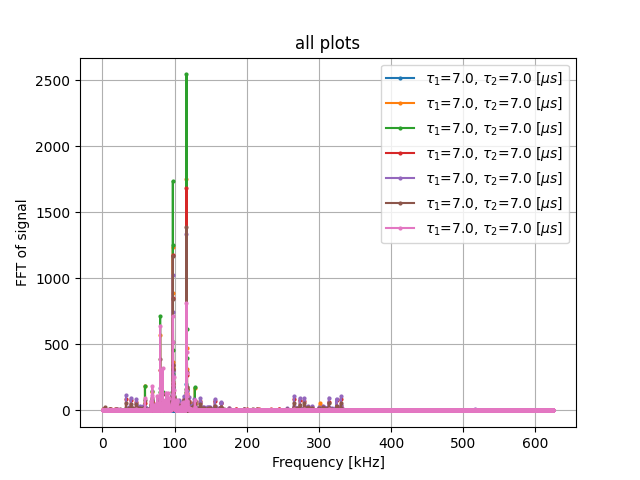

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1517.36it/s]


<IPython.core.display.Javascript object>


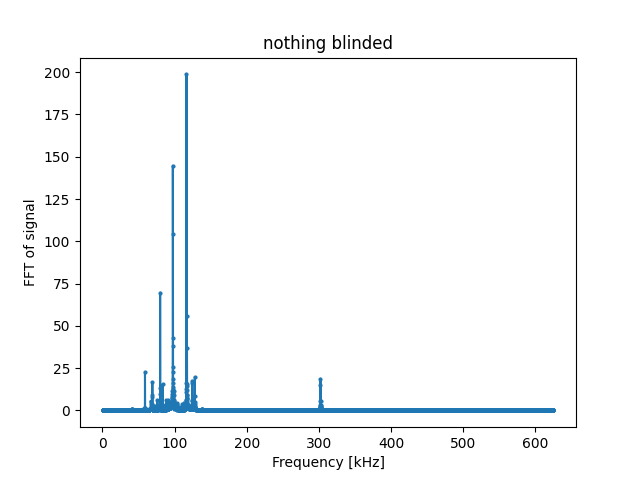

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1524.33it/s]


<IPython.core.display.Javascript object>


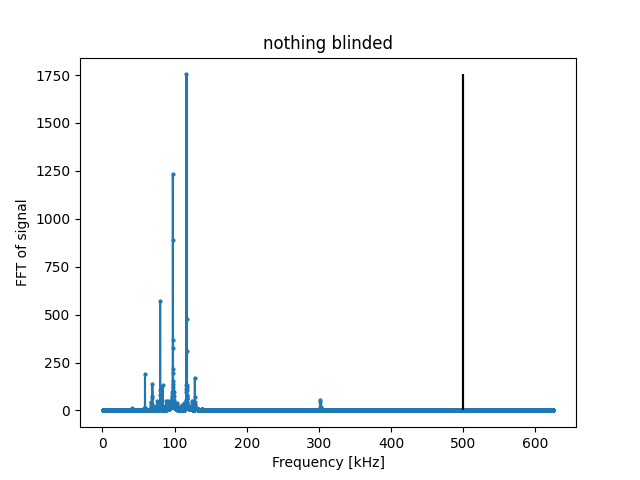

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1505.27it/s]


<IPython.core.display.Javascript object>


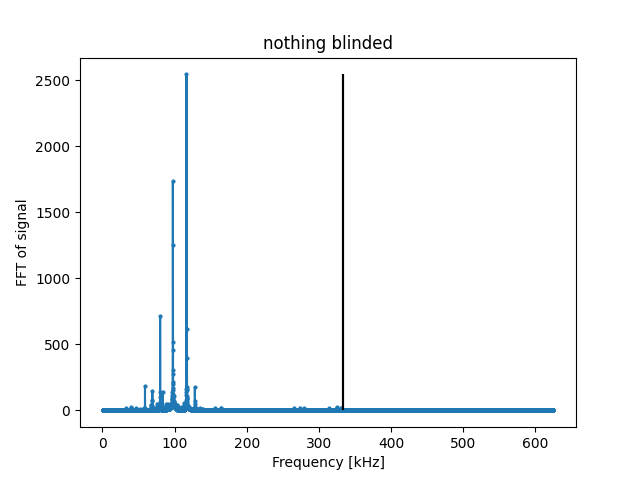

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1523.87it/s]


<IPython.core.display.Javascript object>


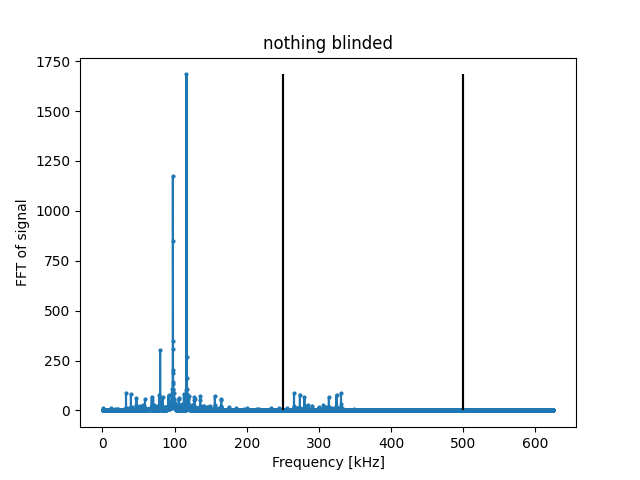

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1524.49it/s]


<IPython.core.display.Javascript object>


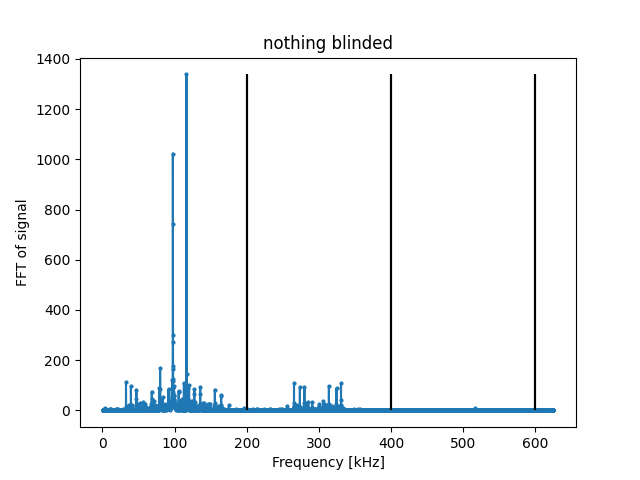

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1520.31it/s]


<IPython.core.display.Javascript object>


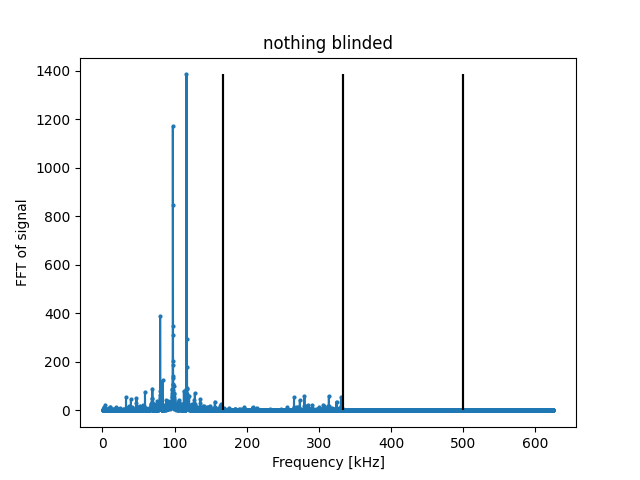

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1526.92it/s]


<IPython.core.display.Javascript object>


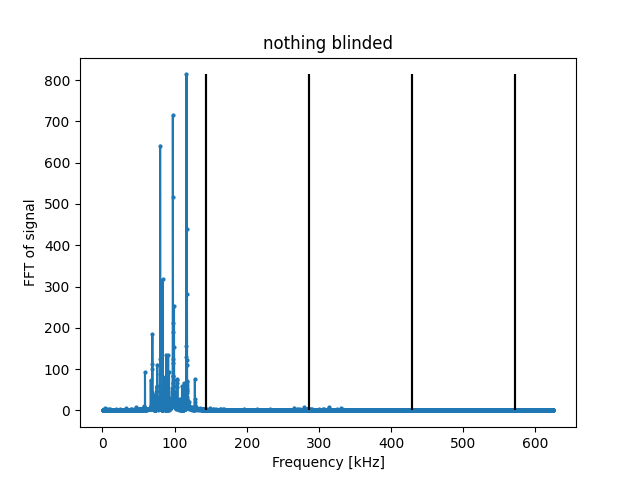

In [276]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 8000
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(dpi=100)

for tau1, tau2, txt in [[1.0e-3, 1.0e-3, 'nothing blinded'],
                        [2.0e-3, 2.0e-3, 'nothing blinded'],
                        [3.0e-3, 3.0e-3, 'nothing blinded'],
                        [4.0e-3, 4.0e-3, 'nothing blinded'],
                        [5.0e-3, 5.0e-3, 'nothing blinded'],
                        [6.0e-3, 6.0e-3, 'nothing blinded'],
                        [7.0e-3, 7.0e-3, 'nothing blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

    plt.figure(dpi=100)
    plt.title(txt)
    plt.plot(freqs, FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1<np.max(freqs):plt.vlines(x=i/tau1,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2<np.max(freqs):plt.vlines(x=i/tau2,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('FFT of signal')
    
    ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )

ax_all.set_title('all plots')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend(loc='upper right')
ax_all.grid()

<IPython.core.display.Javascript object>


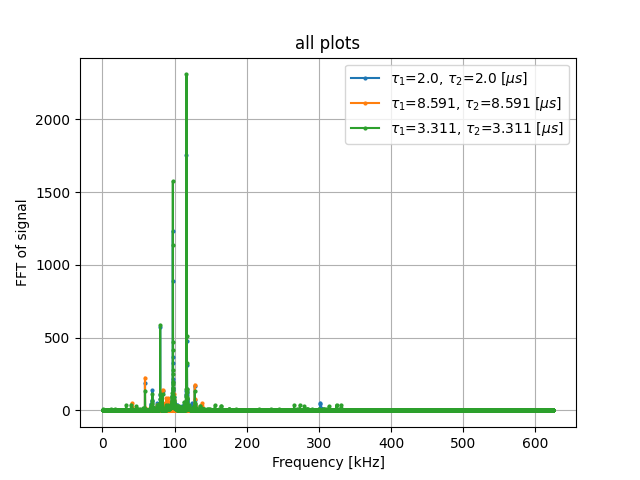

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1487.52it/s]


<IPython.core.display.Javascript object>


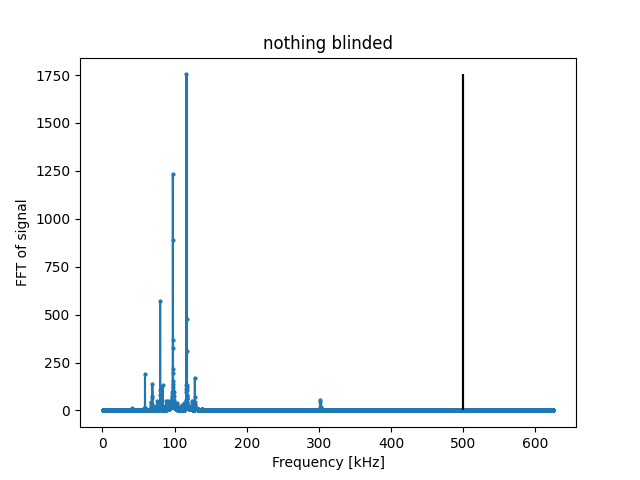

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1486.31it/s]


<IPython.core.display.Javascript object>


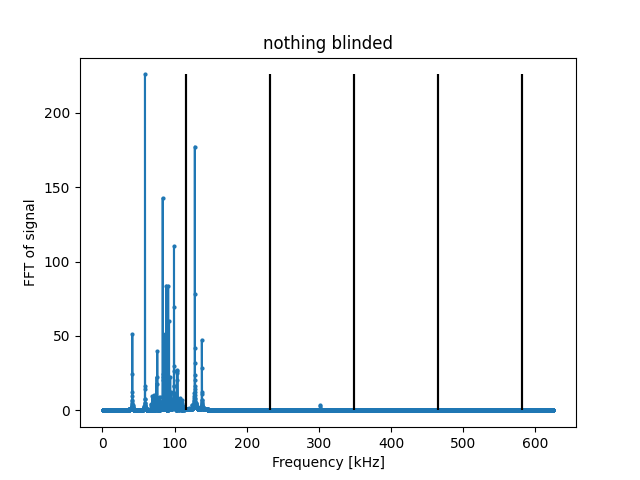

100%|██████████████████████████████████| 12500/12500 [00:08<00:00, 1479.56it/s]


<IPython.core.display.Javascript object>


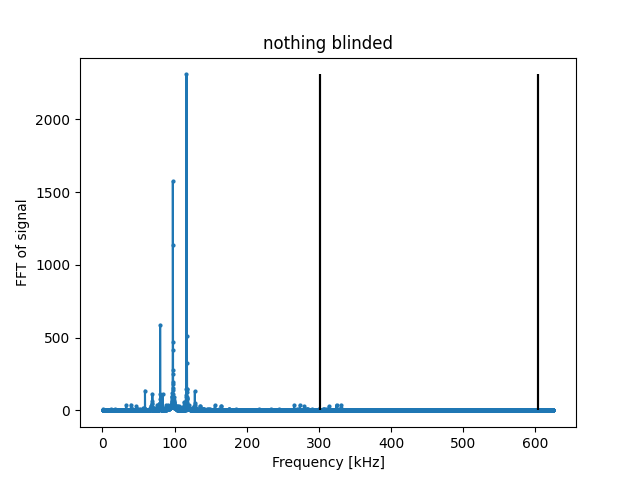

In [277]:
start = 1e-3 # in ms
duration = 10 # in ms
steps = 800
Tc = np.linspace(start,start+duration, steps) # in ms

sample_rate = steps/duration # in kHz
fig_all,ax_all = plt.subplots(dpi=100)

for tau1, tau2, txt in [[2.0e-3, 2.0e-3, 'nothing blinded'],
                        [1/116.4, 1/116.4, 'nothing blinded'],
                        [1/302, 1/302, 'nothing blinded']]:
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in tqdm(Tc):
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]

    plt.figure(dpi=100)
    plt.title(txt)
    plt.plot(freqs, FFT_Signal,'-o',markersize=2, alpha = 1, label=r'$\tau_1$={},'.format(1e-3*(round(tau1l*1e6)))+
               r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2l*1e6))))
    for i in np.arange(1,10,1):
        if i/tau1<np.max(freqs):plt.vlines(x=i/tau1,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
        if i/tau2<np.max(freqs):plt.vlines(x=i/tau2,ymin=min(FFT_Signal),ymax=max(FFT_Signal),color='black')
    plt.xlabel('Frequency [kHz]')
    plt.ylabel('FFT of signal')
    
    ax_all.plot(freqs, FFT_Signal,'-o',markersize=2, alpha=1,label=r'$\tau_1$={},'.format(1e-3*(round(tau1*1e6)))
                   +r' $\tau_2$={} [$\mu s$]'.format(1e-3*(round(tau2*1e6))) )

ax_all.set_title('all plots')
ax_all.set_xlabel('Frequency [kHz]')
ax_all.set_ylabel('FFT of signal')
ax_all.legend(loc='upper right')
ax_all.grid()

# Tau sweep

In [284]:
start = 1e-3 # in ms
duration = 3 # in ms
steps = 2400
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz

spect = []
signal2D = []

tau_sweep = np.arange(1e-3,30e-3,0.5e-3)
for tau1 in tqdm(tau_sweep):
    tau2 =tau1
    ###################################### left
    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for tc in Tc:
        [signal, term1 , term2, term3, term4]= anal_eseem_spin_one_DQR(fL, Azz, Azx, tau1, tau2, tc)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    signal2D.append(Signal)
    freqs = fftfreq(steps, 1/sample_rate)[1:int(steps/2)]
    FFT_Signal = np.abs(np.fft.rfft(Signal))[1:int(steps/2)]
    spect.append(FFT_Signal)


signal2D= np.array(signal2D)
spect= np.array(spect)

100%|██████████████████████████████████████████| 58/58 [01:30<00:00,  1.57s/it]


<IPython.core.display.Javascript object>


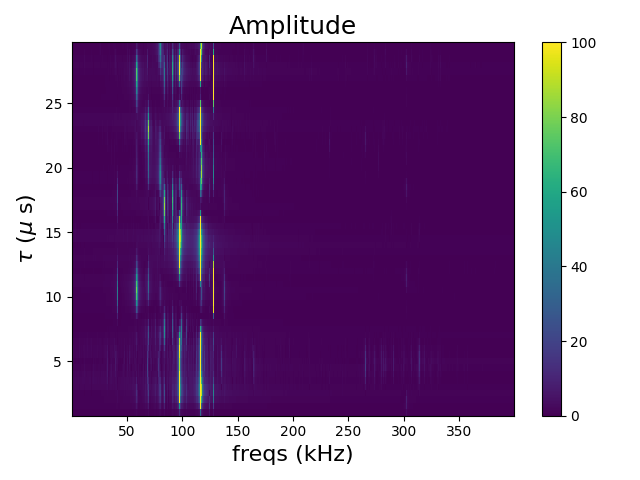

In [297]:
x,y=np.meshgrid(freqs, tau_sweep*1e3)
plt.figure(dpi=100)
plt.pcolormesh(x, y, spect, vmin=0, vmax=100)
plt.title('Amplitude', fontsize =18)
plt.xlabel('freqs (kHz)', fontsize=16)
plt.ylabel(r'$\tau$ ($\mu$ s)', fontsize =16)
plt.colorbar()
plt.tight_layout()
#plt.grid()

<IPython.core.display.Javascript object>


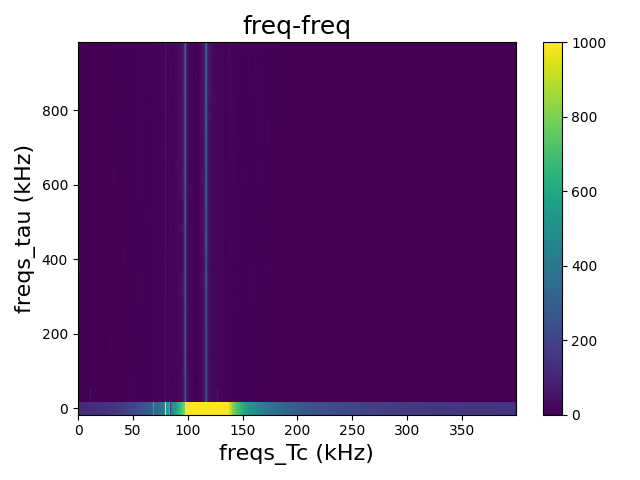

In [305]:
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
freqs_tau = np.fft.fftfreq(n=tau_sweep.shape[0], d = tau_sweep[1]-tau_sweep[0])
x,y = np.meshgrid(freqs_Tc,freqs_tau)

plt.figure(dpi=100)
plt.pcolormesh(x[0:int(len(freqs_tau)/2), 0:int(len(freqs_Tc)/2)],
               y[0:int(len(freqs_tau)/2), 0:int(len(freqs_Tc)/2)],
               np.abs(np.fft.fft2(signal2D))[0:int(len(freqs_tau)/2), 0:int(len(freqs_Tc)/2)], vmin=0, vmax=1000)
plt.title('freq-freq', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

# 2D Hyscore

In [298]:
start = 1e-3 # in ms
duration = 1 # in ms
steps = 800
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz


signal2D = []
tau1, tau2 = 2.5e-3, 2.5e-3

for t1 in tqdm(Tc):

    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for t2 in Tc:
        [signal, term1 , term2, term3, term4]= anal_hyscore_spin_one_DQR(fL, Azz, Azx, tau1, tau2, t1, t2)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    signal2D.append(Signal)


signal2D= np.array(signal2D)

100%|████████████████████████████████████████| 800/800 [13:35<00:00,  1.02s/it]


<IPython.core.display.Javascript object>


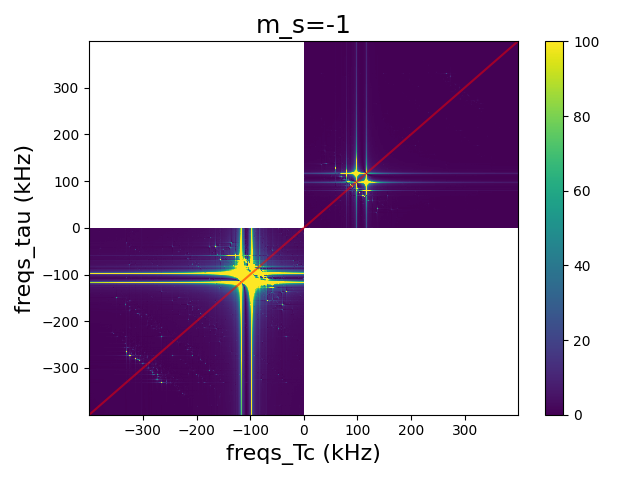

In [311]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.pcolormesh(x[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               y[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               FFT2D_Signal[0:int(len(Tc)/2), 0:int(len(Tc)/2)], vmin=0, vmax=1000)
plt.pcolormesh(x[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               y[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               FFT2D_Signal[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))], vmin=0, vmax=100)
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


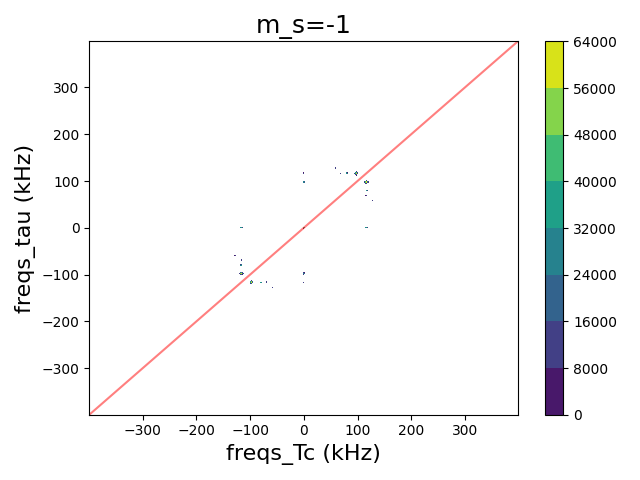

In [319]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.contourf(x,
               y,
               FFT2D_Signal, vmin=0)

plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

# negative-positive frequency area in 2D Hyscore

In [320]:
%matplotlib notebook
# determining the parameters
fL = 83*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([ 213.154]) # kHz
Azx = np.array([3]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=88.8515 kHz
Azz=[213.154] kHz
Azx=[3] kHz
Freq hyp up=[302.02040002] kHz
Blind Spot up=[3.31103462] us
Freq hyp dn=[124.33869674] kHz
Blind Spot dn=[8.04254851] us
k_up=[0.0099331] kHz
k_dn=[0.02412765] kHz


In [334]:
start = 1e-3 # in ms
duration = 0.5 # in ms
steps = 400
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz


signal2D = []
tau1, tau2 = 2.5e-3, 2.5e-3

for t1 in tqdm(Tc):

    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for t2 in Tc:
        [signal, term1 , term2, term3, term4]= anal_hyscore_spin_one_DQR(fL, Azz, Azx, tau1, tau2, t1, t2)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    signal2D.append(Signal)


signal2D= np.array(signal2D)

100%|████████████████████████████████████████| 400/400 [00:22<00:00, 17.66it/s]


<IPython.core.display.Javascript object>


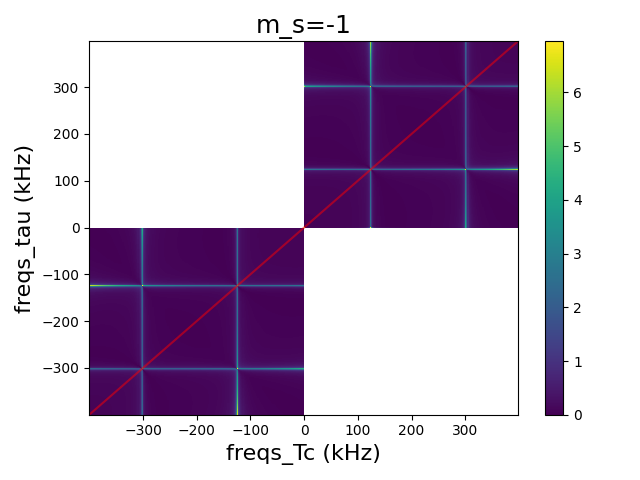

In [337]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.pcolormesh(x[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               y[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               FFT2D_Signal[0:int(len(Tc)/2), 0:int(len(Tc)/2)], vmin=0)
plt.pcolormesh(x[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               y[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               FFT2D_Signal[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))], vmin=0)
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


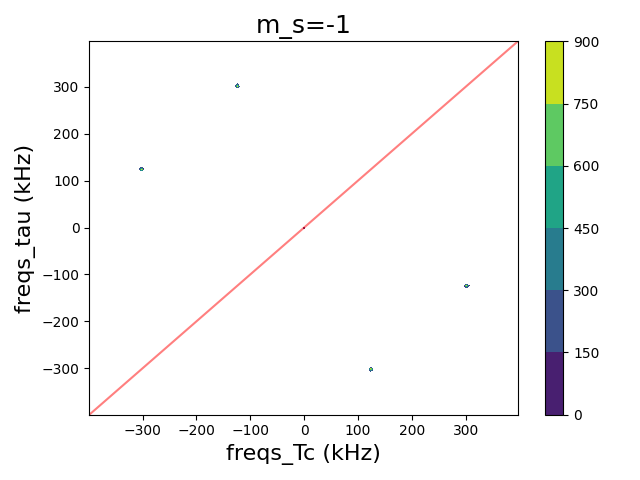

In [338]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.contourf(x,y,FFT2D_Signal, vmin=0)

plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

# Randomly generated nuclear spins

In [343]:
%matplotlib notebook
# determining the parameters
fL = 83*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.random.normal(loc=0, scale =15, size=10) # kHz 10 normal strenght
Azx = np.random.normal(loc=0, scale =15, size=10) # kHz
Azz = np.append(Azz, np.random.normal(loc=0, scale =50, size=5)) # kHz 5 strong
Azx = np.append(Azx, np.random.normal(loc=0, scale =50, size=5)) # kHz
Azz = np.append(Azz, np.random.normal(loc=0, scale =5, size=5)) # kHz 5 weak
Azx = np.append(Azx, np.random.normal(loc=0, scale =5, size=5)) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=88.8515 kHz
Azz=[ 26.12217313  10.1156012  -12.33835136   0.26573613 -14.76383873
 -12.49750082  15.14180639   4.21012702 -16.16644765  -1.64084487
  41.74337137  25.34388469  42.36807231  18.91515112 -33.09056578
   3.92450745  -0.30457037   2.10815222   3.99347529   3.58142942] kHz
Azx=[ -3.88566617  11.34770966 -19.00466446  -5.60233182  -6.11326116
 -25.60689296  -7.61866177  14.29501372  -1.94369826   0.95864809
  53.10734985  74.33500733  62.59124298 -12.92440718  49.24944525
  -1.07215321   8.72814817   2.17239399  -9.31769266   4.29718118] kHz
Freq hyp up=[115.03931464  99.61554916  78.83805671  89.29315705  74.3394479
  80.53350953 104.27200861  94.15314036  72.71103628  87.21592386
 140.98017959 136.25813443 145.38307967 108.53889346  74.39616685
  92.78220234  88.97606036  90.98559022  93.31135426  92.53276288] kHz
Blind Spot up=[ 8.69268044 10.03859346 12.68422944 11.19906646 13.45180827 12.41719138
  9.59030149 10.62099465 13.75307039 11.4657961   7.09319567  7

In [344]:
start = 1e-3 # in ms
duration = 1 # in ms
steps = 800
Tc = np.linspace(start,start+duration, steps) # in ms
sample_rate = steps/duration # in kHz


signal2D = []
tau1, tau2 = 2.5e-3, 2.5e-3

for t1 in tqdm(Tc):

    Term1 = []
    Term2 = []
    Term3 = []
    Term4 = []
    Signal = []
    
    for t2 in Tc:
        [signal, term1 , term2, term3, term4]= anal_hyscore_spin_one_DQR(fL, Azz, Azx, tau1, tau2, t1, t2)
        Term1.append(term1)
        Term2.append(term2)
        Term3.append(term3)
        Term4.append(term4)
        Signal.append(signal)

    
    signal2D.append(Signal)


signal2D= np.array(signal2D)

100%|████████████████████████████████████████| 800/800 [12:01<00:00,  1.11it/s]


<IPython.core.display.Javascript object>


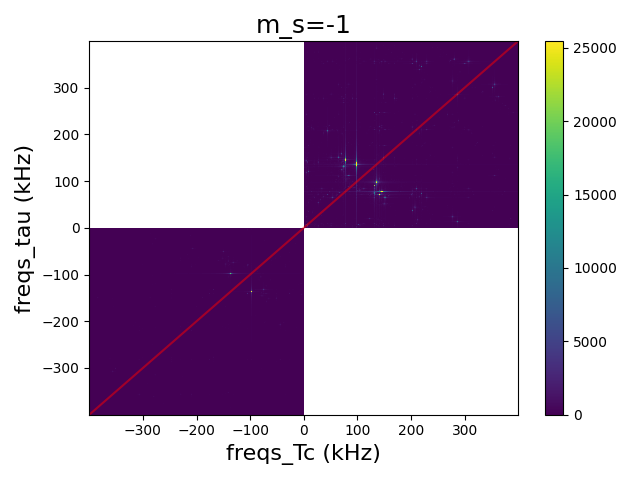

In [347]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.pcolormesh(x[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               y[0:int(len(Tc)/2), 0:int(len(Tc)/2)],
               FFT2D_Signal[0:int(len(Tc)/2), 0:int(len(Tc)/2)], vmin=0, vmax=3000)
plt.pcolormesh(x[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               y[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))],
               FFT2D_Signal[int(len(Tc)/2):int(len(Tc)), int(len(Tc)/2):int(len(Tc))], vmin=0)
plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()

<IPython.core.display.Javascript object>


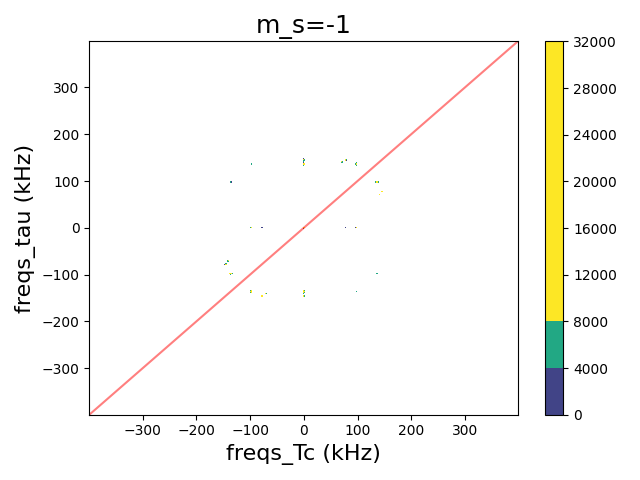

In [349]:
FFT2D_Signal = np.abs(np.fft.fft2(signal2D))
freqs_Tc = np.fft.fftfreq(n=Tc.shape[0], d = Tc[1]-Tc[0])
x, y = np.meshgrid(freqs_Tc,freqs_Tc)

plt.figure(dpi=100)
plt.contourf(x,y,FFT2D_Signal, vmin=0,vmax=10000)

plt.axline((0, 0), slope=1, alpha=0.5, color='red')
plt.title('m_s=-1', fontsize =18)
plt.xlabel('freqs_Tc (kHz)', fontsize=16)
plt.ylabel('freqs_tau (kHz)', fontsize =16)
plt.colorbar()
plt.tight_layout()